In [1]:
import itertools
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn



import pymongo

%matplotlib inline

In [2]:
client = pymongo.MongoClient()
fields = ['title', 'year', 'type', 'metascore', 'genre']
cursor = client.movies_db.movies_collection.find({})

# Get all movies from the collection
movies = pd.DataFrame(list(cursor), columns=fields)
movies_df = movies.copy()

In [3]:
from IPython.display import display, HTML
display(movies_df.head())
display(movies_df.tail())

,title,year,type,metascore,genre
0,Carmencita,1894,movie,N/A,"Documentary, Short"
1,Le clown et ses chiens,1892,movie,N/A,"Animation, Short"
2,Pauvre Pierrot,1892,movie,N/A,"Animation, Comedy, Short"
3,Un bon bock,1892,movie,N/A,"Animation, Short"
4,Blacksmith Scene,1893,movie,N/A,Short


,title,year,type,metascore,genre
734294,,,,,
734295,,,,,
734296,,,,,
734297,The Angel Louise,1955,episode,N/A,Adventure
734298,New Kids on the Block,1999,episode,N/A,"Action, Crime, Drama"


In [4]:
# Clean up data frame

# Remove movies with no specified year
movies_df = movies_df[movies_df['year'] != '']
movies_df = movies_df[movies_df['title'] != '']
# Convert year field to the datetime instance
movies_df = movies_df[movies_df.year.str.match('^\d+$')]

In [5]:
# Convert text year to datetime
movies_df['year'] = pd.to_datetime(movies_df['year'], format='%Y')

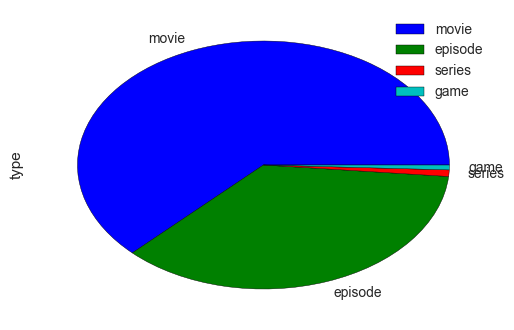

In [6]:
# What types of movies do we have
movies_df['type'].unique()

type_series = movies_df['type']
type_series = type_series.replace('', 'unknown')

type_series.value_counts().plot(kind='pie', legend='True')

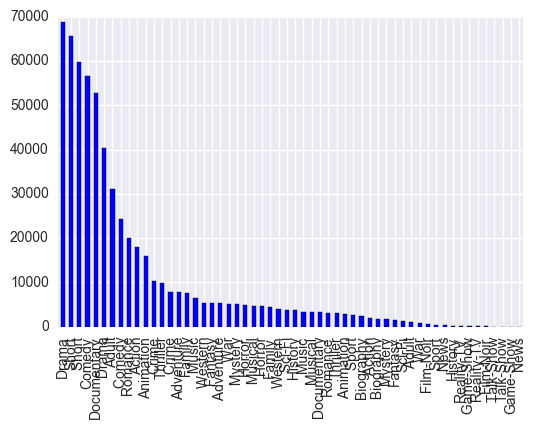

In [7]:
movies = movies_df[movies_df['type'] == 'movie'].copy()

movies = movies[(movies['genre'] != 'N/A') & (movies['genre'] != '')]

df = movies[['year', 'genre']]

genres = pd.DataFrame(df.genre.str.split(',').tolist(), index=df.year).stack()

genres.value_counts().plot.bar()

In [8]:
genres.tail()

year         
1955-01-01  0        Drama
1961-01-01  0        Drama
1987-01-01  0    Adventure
            1        Crime
            2        Drama
dtype: object

In [9]:
genres = movies_df[['year', 'genre']].copy()
splitted_genres = genres['genre'].str.split(",").apply(pd.Series, 1).stack()

In [15]:
s = splitted_genres.copy()

s.index = s.index.droplevel(-1)
s.name = 'genre'

del genres['genre']
splitted_genres = genres.join(s)

KeyError: 'genre'

In [12]:
splitted_genres.tail()

,year,genre
734293,1955-01-01,Adventure
734297,1955-01-01,Adventure
734298,1999-01-01,Action
734298,1999-01-01,Crime
734298,1999-01-01,Drama


In [57]:
pew = splitted_genres.groupby('year')['genre'].value_counts().unstack()
pew.tail()

genre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
year,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,3,NaN,NaN,1,NaN,NaN,5,NaN,...,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN
2016-01-01,NaN,NaN,2,NaN,1,3,1,NaN,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,NaN,NaN,2,NaN,NaN,1,2,NaN,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,3,NaN,NaN,NaN,1,NaN,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
pew = pew.fillna(0)
genres_by_decades = pew.resample('10AS', how='sum')

In [59]:
# genres_by_decades.plot.bar(stacked=True)
genres_by_decades
# genres_by_decades.transpose()

genre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
year,,,,,,,,,,,,,,,,,,,,,
1888-01-01,5,0,0,0,2,126,11,34,14,15,...,1,0,3,0,768,0,0,0,0,0
1898-01-01,19,1,25,3,16,921,63,74,270,23,...,4,0,2,0,3397,0,0,0,5,7
1908-01-01,56,2,139,123,29,5822,431,38,7917,95,...,0,0,219,6,17112,0,0,3,33,211
1918-01-01,66,15,244,86,9,3143,222,36,1432,83,...,0,0,252,12,3225,8,0,15,29,1072
1928-01-01,50,4,331,238,16,1745,380,96,1584,341,...,0,0,226,21,2205,5,0,42,28,645
1938-01-01,34,1,440,375,48,1042,411,255,1704,464,...,0,0,165,8,1640,7,0,47,97,526
1948-01-01,224,1,789,419,122,917,850,230,4794,1758,...,5,0,218,275,1703,7,5,94,88,2146
1958-01-01,166,0,1763,327,331,1845,2935,524,8323,3957,...,15,0,440,182,2600,19,137,289,188,4345
1968-01-01,268,103,1393,221,500,1750,3375,358,9438,3211,...,16,0,361,333,3213,33,192,392,139,1070
